In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import tflearn.data_utils as du
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import array_to_img
import warnings
import matplotlib.image as mpimg
import os 
import cv2
import tensorflow as tf 
from PIL import Image 
from numpy import asarray
from tqdm import tqdm
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askopenfilename
from tkinter import messagebox


In [92]:
#we need to convert the images to a matrix so we can build our test and train sets

DIRECTORY = r"C:\Users\rassa\Documents\Machine Learning A-Z  Udemy\Arabic Handwritten Characters Dataset"
train_data = []
test_data = []
trainPath = DIRECTORY + r"\Train Images 13440x32x32\train"
testPath  = DIRECTORY + r"\Test Images 3360x32x32\test"

def getImgId(imgName):
    return int(imgName.split('_')[1])

def makeData(data, directory, sortingCriteria):
    imgFileNameList = os.listdir(directory)     #get list of directories in path (ie. list of image names)
    imgFileNameList.sort(key = sortingCriteria) #sort list based on key
    
    for img in tqdm(imgFileNameList):  # iterate over the sorted list
                try:
                    img_array = cv2.imread(os.path.join(directory, img) ,cv2.IMREAD_GRAYSCALE)  # convert image to array
                    data.append([img_array])  # add this to our data
                except Exception as e:  # just in case there is a mistake.
                    pass

makeData(train_data, trainPath, getImgId)
makeData(test_data, testPath, getImgId)

# convert to ndarray and reshape
train_data = np.asarray(train_data).reshape([-1, 32, 32, 1])
test_data = np.asarray(test_data).reshape([-1, 32, 32, 1])

100%|████████████████████████████████████████████████████████████████████████████| 3360/3360 [00:01<00:00, 2538.84it/s]


In [93]:
#Load the labels
#header = 0 because
#this creates a pandas dataframe (basically a table)
train_label = pd.read_csv(DIRECTORY + '/csvTrainLabel 13440x1.csv', header = None)
test_label = pd.read_csv(DIRECTORY +  '/csvTestLabel 3360x1.csv', header = None)

In [94]:
#train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1
#test_data = test_data.iloc[:,:].values.astype('float32') we don't need these anymore
test_label = test_label.iloc[:,:].values.astype('int32')-1


In [95]:
train_label = du.to_categorical(train_label,28)

In [96]:
train_data = train_data/255
test_data = test_data/255

In [97]:
#train_data, mean1 = du.featurewise_zero_center(train_data)
#test_data, mean2 = du.featurewise_zero_center(test_data)

In [98]:

recognizer = Sequential()
#for any kind of deep learning we use the sequential model in keras then 
#add layers to it
recognizer.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
#the first 2 dimensional convolusion layer will have 32 filters. filters or kernels are 
#what we use to extract features. in this case they are of size 3x3 (kernel size)
#in the first layer it is necessary to specify the shape so for our case its a
#32x32 pixel image and since it's black and white then it has only one dimension or channel
#if it was colored then we would have (32,32,3)
#activation='relu' this is rectified linear unit. the output filters or convolved layers
#might contain some negative values so we apply the rectifier function (or other functions) to break linearity
recognizer.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(AveragePooling2D(pool_size=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2), strides=(1,1)))
recognizer.add(Dropout(0.25))


recognizer.add(Flatten())
recognizer.add(Dense(units = 256, input_dim = 1024, activation = 'relu'))
recognizer.add(Dense(units = 256, activation = "relu"))
recognizer.add(Dropout(0.5))
recognizer.add(Dense(28, activation = "softmax"))

In [99]:
recognizer.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
average_pooling2d_9 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)       

In [100]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [101]:
recognizer.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [102]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [103]:
datagen.fit(train_data)

In [104]:
recognizer.fit_generator(datagen.flow(train_data,train_label, batch_size=100),
                             epochs = 30, verbose = 2, steps_per_epoch=train_data.shape[0] // 100)

Epoch 1/30
134/134 - 32s - loss: 2.3766 - acc: 0.2840
Epoch 2/30
134/134 - 64s - loss: 1.2785 - acc: 0.5776
Epoch 3/30
134/134 - 89s - loss: 0.9240 - acc: 0.6941
Epoch 4/30
134/134 - 116s - loss: 0.7211 - acc: 0.7602
Epoch 5/30
134/134 - 117s - loss: 0.5824 - acc: 0.8047
Epoch 6/30
134/134 - 116s - loss: 0.5146 - acc: 0.8313
Epoch 7/30
134/134 - 117s - loss: 0.4547 - acc: 0.8510
Epoch 8/30
134/134 - 116s - loss: 0.4124 - acc: 0.8699
Epoch 9/30
134/134 - 118s - loss: 0.3701 - acc: 0.8802
Epoch 10/30
134/134 - 117s - loss: 0.3423 - acc: 0.8915
Epoch 11/30
134/134 - 116s - loss: 0.3230 - acc: 0.8988
Epoch 12/30
134/134 - 116s - loss: 0.3005 - acc: 0.9020
Epoch 13/30
134/134 - 117s - loss: 0.2752 - acc: 0.9105
Epoch 14/30
134/134 - 115s - loss: 0.2653 - acc: 0.9174
Epoch 15/30
134/134 - 118s - loss: 0.2528 - acc: 0.9184
Epoch 16/30
134/134 - 118s - loss: 0.2479 - acc: 0.9209
Epoch 17/30
134/134 - 117s - loss: 0.2370 - acc: 0.9244
Epoch 18/30
134/134 - 116s - loss: 0.2329 - acc: 0.9265
Epoc

In [117]:
predictions = recognizer.predict(test_data)
predictions = np.argmax(predictions,axis = 1)

In [106]:
cm = confusion_matrix(test_label, predictions)

In [118]:
# accuracy: (tp + tn) / (p + n)
accuracy = sum(cm[i][i] for i in range(28)) / test_label.shape[0]
print("accuracy = " + str(accuracy))

accuracy = 0.9642857142857143


In [108]:
print(cm)

[[120   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0 120   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0 117   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   1   0   0   0]
 [  0   0   4 113   0   0   0   0   0   0   0   0   0   0   1   0   0   0
    0   0   0   1   0   0   1   0   0   0]
 [  0   0   0   0 120   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2 118   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1 118   0   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 113   2   3   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   4 107   0   2   0   0   0   1   

* Enter the alpha value [1.0-3.0]: 1.5
* Enter the beta value [0-100]: 0
179.0
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


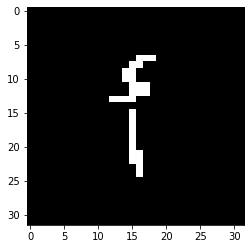

In [124]:

# Read image given by user


Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
image = cv2.imread(filename)#r"C:\Users\rassa\Desktop\Desktop2.0\CNN\9alb-Ba2-0.png") #(cv.samples.findFile(args.input))

contrast_img = np.zeros(image.shape, image.dtype)

alpha = 1.0 # Simple contrast control
beta = 0    # Simple brightness control

# Initialize values
try:
    alpha = float(input('* Enter the alpha value [1.0-3.0]: '))
    beta = int(input('* Enter the beta value [0-100]: '))
except ValueError:
    print('Error, not a number')
    
# Do the operation new_image(i,j) = alpha*image(i,j) + beta
# Instead of these 'for' loops we could have used simply:
# new_image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
# but we wanted to show you how to access the pixels :)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        for c in range(image.shape[2]):
            # the clip makes sure that the new values of the pixel are between 0 and 255
            contrast_img[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)
        
#removethe three dimensions and turn image to gray scale
im_gray = cv2.cvtColor(contrast_img, cv2.COLOR_BGR2GRAY)
#binarize the image using Otsu method to get the threshold, binarize to black and white(ie. 255)
th, im_gray_th_otsu = cv2.threshold(im_gray, 128, 255, cv2.THRESH_OTSU)
#resizing...
resized = cv2.resize(im_gray_th_otsu, (32,32), interpolation = cv2.INTER_AREA)

#print the threshold because I'm curious
print(th)

final_img = np.zeros(resized.shape, resized.dtype)
for y in range(resized.shape[0]):
    for x in range(resized.shape[1]):
        if resized[y,x] < 125:     
            final_img[y,x] = 255
        else :
            final_img[y,x] = 0

#Show the images so we can compare them (use the cv2.imshow if you want to ee them all at once)
#cv2.imshow('New Image', im_gray_th_otsu)
#cv2.imshow('Original Image', image)
#cv2.imshow('Contrast image', contrast_img)
#cv2.imshow('resized Image', resized)
#cv2.imshow('final Image', final_img)
plt.imshow(image)
plt.imshow(contrast_img)
plt.imshow(im_gray_th_otsu, cmap='gray', vmin=0, vmax=255)
plt.imshow(resized, cmap='gray', vmin=0, vmax=255)
plt.imshow(final_img, cmap='gray', vmin=0, vmax=255)


final_img = np.asarray(final_img).reshape([-1, 32, 32, 1])
#final_img.reshape([1,32,32,1])
#final_img = np.expand_dims(final_img, -1)

predictions_single = recognizer.predict(final_img)
print(predictions_single)

#let's get our label
label = 0
for i in range(28):
    if predictions_single[0][i] == 1:
        label = i+1
        break


In [123]:
print(label)

1


In [ ]:
#Here I tried to create a simple GUI but I didn't have enough time to do it

def outputMsg:
    messagebox.showinfo("Prediction", "Your letter is " + label)

    def switch():
   
    option = int(label)
 
    def alif():
        message = "Alif"
    def ba():
        message = "ba2"
    def ta():
        message = "ta2"
    def tha():
        message = "tha2"
    def jha():
        message = "jha2"
    def ha():
        message = "7a2"
    def kha():
        message = "5a2"
    def da():
        message = "da2"
    def ra():
        message = "ra2"
    def za():
        message = "za2"
    def thal():
        message = "thal"
    def sa():
        message = "sa2"
    def sha():
        message = "sha2"
    def sad():
        message = "saad"
    def thad():
        message = "thad"
    def tta():
        message = "tta2"
    def ththa():
        message = "ththa2"
    def aayn():
        message = "3ayn"
    def ghayn():
        message = "ghayn"
    def fa():
        message = "fa2"
    def kka():
        message = "9a2"
    def ka():
        message = "ka2"
    def lam():
        message = "lam"
    def meem():
        message = "meem"
    def noon():
        message = "noon"
    def haa():
        message = "haa2"
    def waw():
        message = "waw"
    def yaa():
        message = "yaa2"
        
    def default():
        message = "Something Went Wrong!"
 
    dict = {
        1 : alif,
        2 : ba,
        3: ta
        4: tha
        5: jha
        6: ha,
        7: kha,
        8: da,
        9: thal,
        10: ra 
        11: za 
        12: sa, 
        13: sha,
        14: sad,
        15: thad,
        16: tta,
        17: ththa,
        18: aayn,
        19: ghayn,
        20: fa,
        21: kka,
        22: ka,
        23: lam,
        24: meem,
        25: noon,
        26: haa,
        27: waw,
        28: yaa
 
    }
    dict.get(option,default)() # get() method returns the function matching the argument
 
 
switch()